In [1]:
# Importamos las librerías necesarías y fijamos la semilla.
import numpy as np
import random
import scipy
from scipy.stats import uniform as spuniform
import matplotlib.pyplot as plt
import collections

from matplotlib import pyplot
import math
import statistics
import pandas as pd
import time
!pip install networkx
import networkx as nx
import os
import re
from matplotlib import colors

np.random.seed(11)

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Calcula cuánto tiempo ha pasado desde un momento dado hasta el momento actual.
def timeSince(since):
    now = time.time_ns()
    s = now - since
    return s*10**(-9)

Definimos un función que entrega un grafo a partir de un número de vertices V y un a lista de aristas con sus pesos correspondientes.

In [3]:
def grafo(V,E):
    G = nx.Graph()
    G.add_nodes_from(range(V))
    G.add_edges_from([(key[0],key[1],{"weight": E[key]}) for key in list(E.keys())])
    return G 

In [4]:
def costo(ruta,distancias):
    return np.sum(distancias[ruta[i],ruta[i+1]] for i in range(len(ruta)-1))

In [5]:
# Beta lineal
def beta1(n,C):
    return n/C

# Beta cuadrático.
def beta2(n,C):
    return (n**2)/C

# Beta exponencial.
def beta3(n,C):
    return np.exp(n)/C

Se define una función que grafica el camino sobre un grafo G.

In [6]:
def plotear(G,camino):
    plt.figure()
    plt.scatter([ciudades[i][0] for i in range(len(P))],[ciudades[i][1] for i in range(len(P))], marker="o")
    for i in range(len(sigma)-1):
        plt.plot([ciudades[sigma[i]][0],ciudades[sigma[i+1]][0]],[ciudades[sigma[i]][1],ciudades[sigma[i+1]][1]],'k-')

Definimos una función que entrega un grafo regular de n vértices, todos de grado d. Los pesos de las aristas son asignados aleaoriamente entre el 1 y el 100.

In [7]:
def graforegular(d,n):
    G = nx.random_regular_graph(d,n)
    for e in G.edges():
        G[e[0]][e[1]]["weight"] = np.random.randint(1,100)
    return G

Función que realiza el Simulated Annealing dado un grafo G, configuración inicial $\sigma_0$, y sus parámetros: C, $\beta_n$ y número de pasos.

In [8]:
def SimAnn(G,sigma0,C,beta,pasos=10**4):
    inicial= sigma0[0]
    final= sigma0[-1]
    # Se define las uniformes para cada paso.
    U = np.random.uniform(size = pasos)
    sigmas = [sigma0]
    w = [nx.path_weight(G,sigma0,"weight")]
    conteo=0
    for i in range(pasos-1):
        # Configuración anterior.
        sigma= sigmas[i]
        # Definimos beta_n según la función dada.
        betan= beta(i,C)
        # Sacamos un vecino como otra cosa más rara.
        x = random.choice(sigma[:-1])
        index = min(np.where(np.array(sigma) == x)[0])
        caminos= []
        for node in sigma[index+1:]:
            caminos.extend(list(nx.all_simple_paths(G,x,node,2)))
        add = random.choice(caminos)
        tau = sigma[:index]
        tau.extend(add)
        indexf = min(np.where(np.array(sigma) == add[-1])[0])
        tau.extend(sigma[indexf+1:])
        # Remove loops.
        loops = [item for item, count in collections.Counter(tau).items() if count > 1]
        while len(loops)>0:
            copia = loops[0]
            borrar1 = min(np.where(np.array(tau) == copia)[0])
            borrar2 = max(np.where(np.array(tau) == copia)[0])
            del tau[borrar1:borrar2]
            loops = [item for item, count in collections.Counter(tau).items() if count > 1]
        # Costo anterior.
        ws = nx.path_weight(G,sigma,"weight")
        # Costo vecino.
        wt = nx.path_weight(G,tau,"weight")
        dif = np.exp(-betan*(wt-ws))
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(wt)
        else:
            sigmas.append(sigma)
            w.append(ws)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas

Función auxiliar para leer archivos de formato .stp

In [9]:
def read_stp(file_name):
    with open(file_name) as f:
        lines = f.readlines()

        sections = "Comment Graph Terminals".split()
        current_section = ""
        n, m = 0, 0
        col_s = []  # node source
        col_t = []  # node target
        col_w = []  # weight fun
        terminals = []
        for l in lines:
            if "SECTION" in l:
                current_section = l.replace("SECTION", "").strip()
            elif "END" in l:
                current_section = ""
            elif current_section == "Graph":
                if "Nodes" in l:
                    n = int(re.findall(r"\d+", l)[0])
                elif "Edges" in l:
                    m = int(re.findall(r"\d+", l)[0])
                elif "E" in l:
                    s, t, w_st = re.findall(r"\d+", l)
                    s, t, w_st = int(s), int(t), int(w_st)
                    col_s.append(s)
                    col_t.append(t)
                    col_w.append(w_st)
            elif current_section == "Terminals":
                if "T " in l:
                    terminals.append(int(re.findall(r"\d+", l)[0]))

        df_edges_G = pd.DataFrame({
            "SOURCE": col_s,
            "TARGET": col_t,
            "WEIGHT": col_w
        })

        return df_edges_G, terminals

## Implementación

Comenzamos con un grafo conexo de 4 vértices, para encontrar su solución de forma manual más fácil y verificar si el Simulated Annealing puede obtener el óptimo.

In [10]:
# Parámetros a cambiar.
peso1, peso2, peso3, peso4, peso5, peso6 = 4, 7, 10, 2, 5, 2

dic = {(0,1): peso1, (0,2): peso2, (0,3): peso3, (1,2): peso4, (1,3): peso5, (2,3): peso6}
G  = grafo(4,dic)
# Solución por Dijkstra.
p = nx.shortest_path(G,0,3,"weight")
ruta = [0,1,3]
pasos = 10**2
# Solución por S.A.
s,w,W,S = SimAnn(G,ruta,10,beta2,pasos)
print(s)
print(p)

[0, 1, 2, 3]
[0, 1, 2, 3]


Observamos el grafo y sus soluciónes:

{(0, 1): Text(0.09815341261576085, -0.18489824461931026, '4'),
 (0, 2): Text(0.019018949370788796, 0.6776184231347513, '7'),
 (0, 3): Text(-0.5510312113990173, -0.13748333224593828, '10'),
 (1, 2): Text(0.5510312113990178, 0.1374833322459384, '2'),
 (1, 3): Text(-0.019018949370788296, -0.6776184231347513, '5'),
 (2, 3): Text(-0.09815341261576035, 0.18489824461931037, '2')}

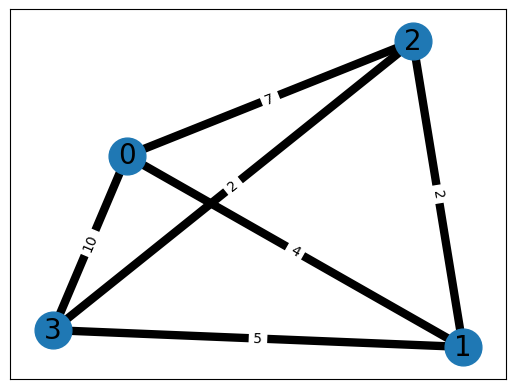

In [11]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=700)

nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# Edges.
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(0.06264430433733939, 0.226041636022335, '4'),
 (0, 2): Text(0.1660613511149557, -0.734167317469999, '7'),
 (0, 3): Text(-0.6327247896264638, 0.03979104650766607, '10'),
 (1, 2): Text(0.6327247896264635, -0.03979104650766596, '2'),
 (1, 3): Text(-0.166061351114956, 0.7341673174699992, '5'),
 (2, 3): Text(-0.0626443043373397, -0.2260416360223349, '2')}

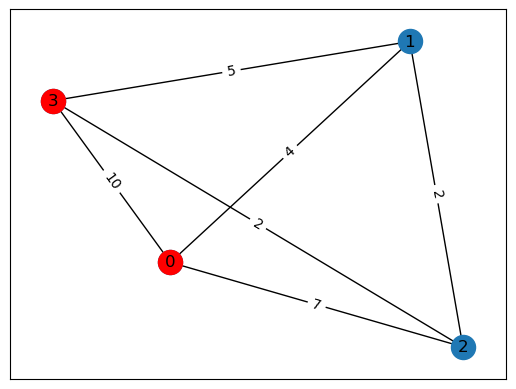

In [12]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,3], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(0.2433512290237222, -0.04781550370430443, '4'),
 (0, 2): Text(-0.7539442021872165, -0.2284225459000532, '7'),
 (0, 3): Text(-0.002704568789060835, 0.665552086241902, '10'),
 (1, 2): Text(0.0027045687890613346, -0.6655520862419023, '2'),
 (1, 3): Text(0.7539442021872169, 0.22842254590005293, '5'),
 (2, 3): Text(-0.2433512290237217, 0.04781550370430415, '2')}

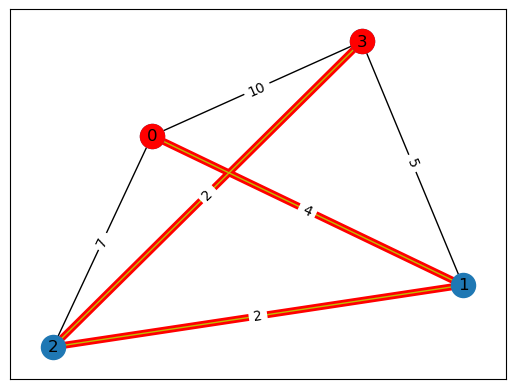

In [13]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,3], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_edges(G,pos=pos,edgelist=edges,edge_color = "r",width=5)
nx.draw_networkx_edges(G,pos=pos,edgelist=edgep,edge_color = "y")
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

## Implementación en Grafos aleatorios

Creamos un grafo regular cualquiera e implementamos Simulated Annealing para distintos valores de c y funciones $\beta$:

In [14]:
G = graforegular(30,80)
p = nx.shortest_path(G,6,25,"weight")
w = nx.path_weight(G,p,"weight")
ruta = random.choice(list(nx.all_simple_paths(G,6,25,5)))

In [15]:
# Parámetros a cambiar.
c = [1,5,10,100]
pasos = [10**2, 10**3, 10**4,10**5]
i=3
# beta = beta1, beta2, beta3 (lineal, cuadrática, exponencial).
beta = beta2
# c = c[0], c[1], c[2], c[3] (1, 5, 10, 100).
c = c[3]

s10,w10,W10,S10 = SimAnn(G,ruta,c,beta,pasos[i])

Observamos el peso total para cada camino encontrado y se compara con el resultado encontrado por Dijkstra:

In [16]:
d = {"Método": [beta.__name__] , "C="+str(c): [nx.path_weight(G,s10,"weight")], "Dijkstra": [nx.path_weight(G,p,"weight")]}
df = pd.DataFrame(d)
df

,Método,C=100,Dijkstra
0,beta2,10,10


Observamos la evolución de los costos en cada paso para cada Simulated Annealing:

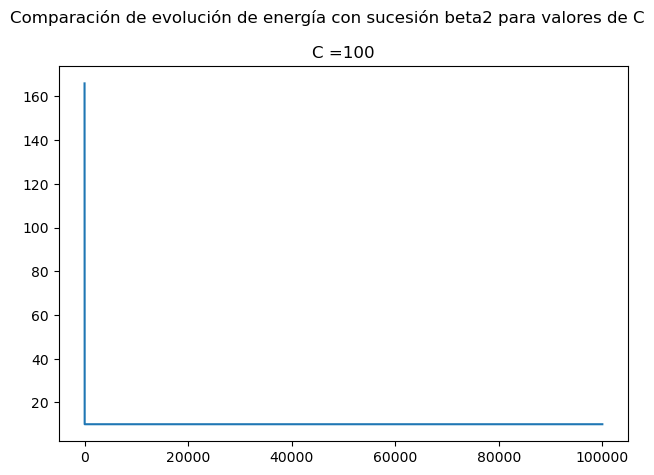

In [17]:
X = range(pasos[i])
fig, axs = plt.subplots(1, 1)
axs.plot(X,W10)
axs.set_title('C =' + str(c))
fig.suptitle("Comparación de evolución de energía con sucesión "+beta.__name__+" para valores de C")
fig.tight_layout()